# Image generation with Segmind Stable Diffusion 1B (SSD-1B) model and OpenVINO

The [Segmind Stable Diffusion Model (SSD-1B)](https://github.com/segmind/SSD-1B?ref=blog.segmind.com) is a distilled 50% smaller version of the Stable Diffusion XL (SDXL), offering a 60% speedup while maintaining high-quality text-to-image generation capabilities. It has been trained on diverse datasets, including Grit and Midjourney scrape data, to enhance its ability to create a wide range of visual content based on textual prompts.
This model employs a knowledge distillation strategy, where it leverages the teachings of several expert models in succession, including SDXL, ZavyChromaXL, and JuggernautXL, to combine their strengths and produce impressive visual outputs.

![image](https://user-images.githubusercontent.com/82945616/277419571-a5583e8a-6a05-4680-a540-f80502feed0b.png)


In this tutorial, we consider how to run the SSD-1B model using OpenVINO. Then we will consider [LCM distilled version of segmind/SSD-1B](https://huggingface.co/latent-consistency/lcm-ssd-1b) that allows to reduce the number of inference steps to only between 2 - 8 steps.

We will use a pre-trained model from the [Hugging Face Diffusers](https://huggingface.co/docs/diffusers/index) library. To simplify the user experience, the [Hugging Face Optimum Intel](https://huggingface.co/docs/optimum/intel/index) library is used to convert the models to OpenVINO™ IR format.

#### Table of contents:
- [Install Prerequisites](#Install-prerequisites)
- [SSD-1B Base model](#SSD-1B-Base-model)
  - [Select inference device SSD-1B Base model](#Select-inference-device-SSD-1B-Base-model)
  - [Run Text2Image generation pipeline](#Run-Text2Image-generation-pipeline)
  - [Text2image Generation Interactive Demo](#Text2image-Generation-Interactive-Demo)
- [Latent Consistency Model (LCM)](#Latent-ConsistencyModel-(LCM))
  - [Extra prerequisites](#Extra-prerequisites)
  - [Infer the original model](#Infer-the-original-model)
  - [Convert the model to OpenVINO IR](#Convert-the-model-to-OpenVINO-IR)
    - [Imports](#Imports)
    - [Convert VAE](#Convert-VAE)
    - [Convert U-NET](#Convert-U-NET)
    - [Convert Encoders](#Convert-Encoders)
  - [Compiling models](#Compiling-models)
  - [Building the pipeline](#Building-the-pipeline)
  - [Inference](#Inference)
  - [Image2Image Generation with LCM Interactive Demo](#Image2Image-Generation-with-LCM-Interactive-Demo)

## Install prerequisites
[back to top ⬆️](#Table-of-contents:)

In [ ]:
%pip install -q "git+https://github.com/huggingface/optimum-intel.git"
%pip install -q "openvino>=2023.1.0"
%pip install -q --upgrade-strategy eager "invisible-watermark>=0.2.0" "transformers>=4.33" "accelerate" "onnx" "onnxruntime" safetensors "diffusers>=0.22.0"
%pip install -q gradio

## SSD-1B Base model
[back to top ⬆️](#Table-of-contents:)

We will start with the base model part, which is responsible for the generation of images of the desired output size. 
[SSD-1B](https://huggingface.co/segmind/SSD-1B) is available for downloading via the [HuggingFace hub](https://huggingface.co/models). It already provides a ready-to-use model in OpenVINO format compatible with [Optimum Intel](https://huggingface.co/docs/optimum/intel/index).

To load an OpenVINO model and run an inference with OpenVINO Runtime, you need to replace diffusers `StableDiffusionXLPipeline` with Optimum `OVStableDiffusionXLPipeline`. In case you want to load a PyTorch model and convert it to the OpenVINO format on the fly, you can set `export=True`.  

You can save the model on disk using the `save_pretrained` method.

In [1]:
from pathlib import Path
from optimum.intel.openvino import OVStableDiffusionXLPipeline


model_id = "segmind/SSD-1B"
model_dir = Path("openvino-ssd-1b")

/home/maleksandr/test_notebooks/ssd-1b-pr/openvino_notebooks/notebooks/248-stable-diffusion-xl/venv/lib/python3.10/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/maleksandr/test_notebooks/ssd-1b-pr/openvino_notebooks/notebooks/248-stable-diffusion-xl/venv/lib/python3.10/site-packages/torch/cuda/__init__.py:740: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() if nvml_count < 0 else nvml_count


### Select inference device SSD-1B Base model
[back to top ⬆️](#Table-of-contents:)

select device from dropdown list for running inference using OpenVINO

In [2]:
import ipywidgets as widgets
import openvino as ov


core = ov.Core()

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

In [3]:
import gc


if not model_dir.exists():
    text2image_pipe = OVStableDiffusionXLPipeline.from_pretrained(model_id, compile=False, device=device.value, export=True)
    text2image_pipe.half()
    text2image_pipe.save_pretrained(model_dir)
    text2image_pipe.compile()
    gc.collect()
else:
    text2image_pipe = OVStableDiffusionXLPipeline.from_pretrained(model_dir, device=device.value)

Compiling the vae_decoder to AUTO ...
Compiling the unet to AUTO ...
Compiling the text_encoder_2 to AUTO ...
Compiling the vae_encoder to AUTO ...
Compiling the text_encoder to AUTO ...


### Run Text2Image generation pipeline
[back to top ⬆️](#Table-of-contents:)

Now, we can run the model for the generation of images using text prompts. To speed up evaluation and reduce the required memory we decrease `num_inference_steps` and image size (using `height` and `width`).  You can modify them to suit your needs and depend on the target hardware. We also specified a `generator` parameter based on a numpy random state with a specific seed for results reproducibility.
>**Note**: Generating a default size 1024x1024 image requires about 53GB for the SSD-1B model in case if the converted model is loaded from disk and up to 64GB RAM for the SDXL model after exporting.

/home/maleksandr/test_notebooks/ssd-1b-pr/openvino_notebooks/notebooks/248-stable-diffusion-xl/venv/lib/python3.10/site-packages/optimum/intel/openvino/modeling_diffusion.py:565: FutureWarning: `shared_memory` is deprecated and will be removed in 2024.0. Value of `shared_memory` is going to override `share_inputs` value. Please use only `share_inputs` explicitly.
  outputs = self.request(inputs, shared_memory=True)


  0%|          | 0/15 [00:00<?, ?it/s]

/home/maleksandr/test_notebooks/ssd-1b-pr/openvino_notebooks/notebooks/248-stable-diffusion-xl/venv/lib/python3.10/site-packages/optimum/intel/openvino/modeling_diffusion.py:599: FutureWarning: `shared_memory` is deprecated and will be removed in 2024.0. Value of `shared_memory` is going to override `share_inputs` value. Please use only `share_inputs` explicitly.
  outputs = self.request(inputs, shared_memory=True)
/home/maleksandr/test_notebooks/ssd-1b-pr/openvino_notebooks/notebooks/248-stable-diffusion-xl/venv/lib/python3.10/site-packages/optimum/intel/openvino/modeling_diffusion.py:615: FutureWarning: `shared_memory` is deprecated and will be removed in 2024.0. Value of `shared_memory` is going to override `share_inputs` value. Please use only `share_inputs` explicitly.
  outputs = self.request(inputs, shared_memory=True)


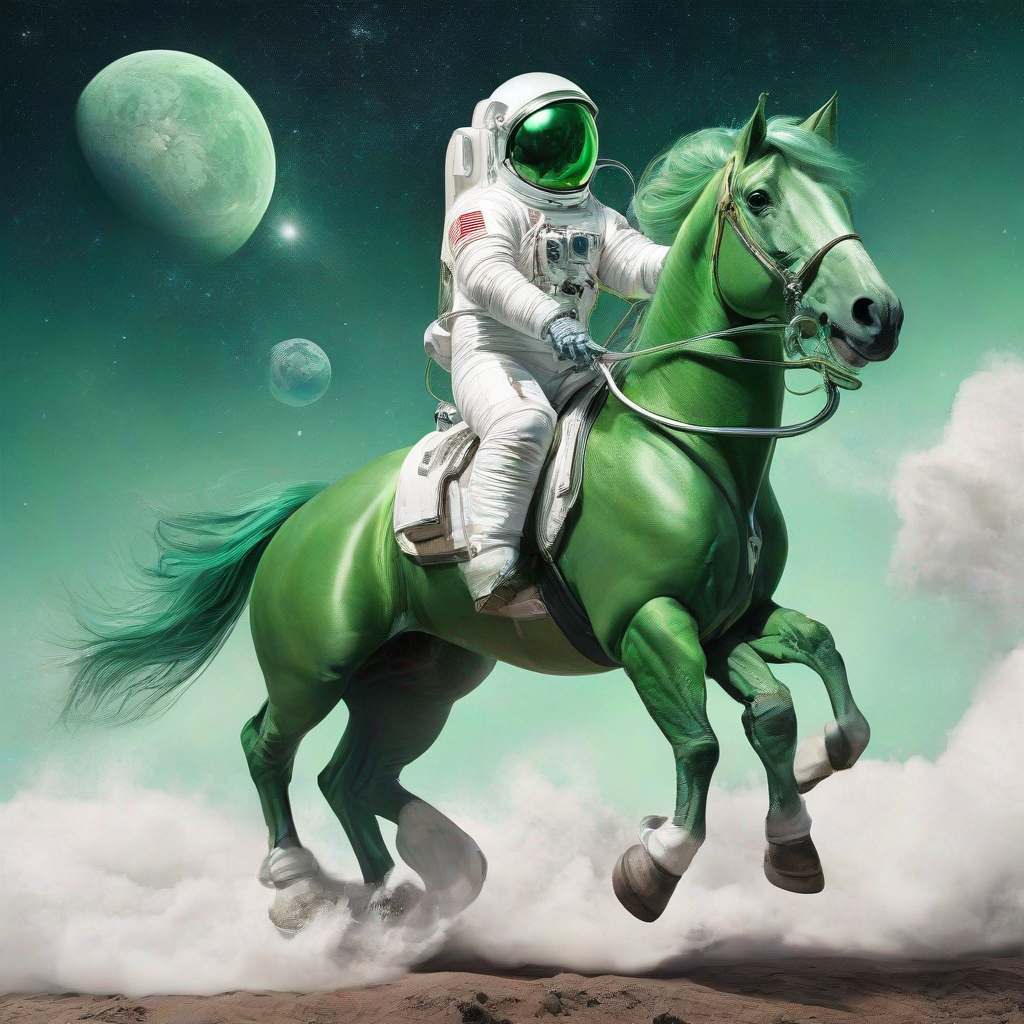

In [4]:
prompt = "An astronaut riding a green horse"  # Your prompt here
neg_prompt = "ugly, blurry, poor quality"  # Negative prompt here
image = text2image_pipe(prompt=prompt, num_inference_steps=15, negative_prompt=neg_prompt).images[0]
image

Generating a 512x512 image requires about 27GB for the SSD-1B model and about 42GB RAM for the SDXL model in case if the converted model is loaded from disk.

  0%|          | 0/15 [00:00<?, ?it/s]

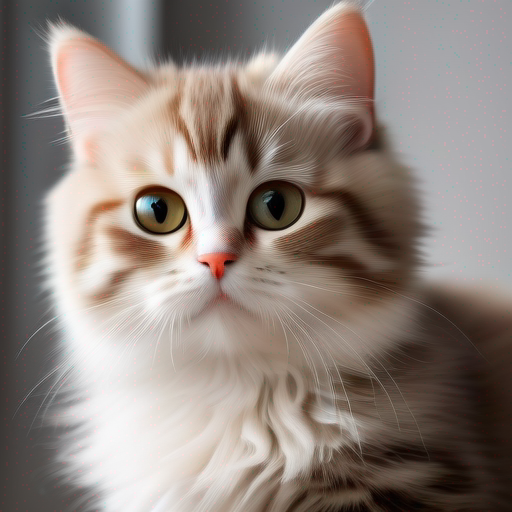

In [5]:
import numpy as np


prompt = "cute cat 4k, high-res, masterpiece, best quality, soft lighting, dynamic angle"
image = text2image_pipe(prompt, num_inference_steps=15, height=512, width=512, generator=np.random.RandomState(314)).images[0]
image

### Image2Image Generation Interactive Demo
[back to top ⬆️](#Table-of-contents:)

In [ ]:
import gradio as gr


prompt = "An astronaut riding a green horse"
neg_prompt = "ugly, blurry, poor quality"

def generate_from_text(text_promt, neg_prompt, seed, num_steps):
    result = text2image_pipe(text_promt, negative_prompt=neg_prompt, num_inference_steps=num_steps, generator=np.random.Generator(seed), height=512, width=512).images[0]
    return result


with gr.Blocks() as demo:
    with gr.Column():
        positive_input = gr.Textbox(label="Text prompt")
        neg_input = gr.Textbox(label="Negative prompt")
        with gr.Row():
            seed_input = gr.Slider(0, 10_000_000, value=42, label="Seed")
            steps_input = gr.Slider(label="Steps", value=10, step=1)
            btn = gr.Button()
        out = gr.Image(label="Result", type="pil", width=512)
        btn.click(generate_from_text, [positive_input, neg_input, seed_input, steps_input], out)
        gr.Examples([
            [prompt, neg_prompt, 999, 20], 
            ["underwater world coral reef, colorful jellyfish, 35mm, cinematic lighting, shallow depth of field,  ultra quality, masterpiece, realistic", neg_prompt, 89, 20],
            ["a photo realistic happy white poodle dog ​​playing in the grass, extremely detailed, high res, 8k, masterpiece, dynamic angle", neg_prompt, 1569, 15],
            ["Astronaut on Mars watching sunset, best quality, cinematic effects,", neg_prompt, 65245, 12],
            ["Black and white street photography of a rainy night in New York, reflections on wet pavement", neg_prompt, 48199, 10]
        ], [positive_input, neg_input, seed_input, steps_input])

try:
    demo.queue().launch(debug=True)
except Exception:
    demo.queue().launch(debug=True, share=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/

## Latent Consistency Model (LCM)
[back to top ⬆️](#Table-of-contents:)

Latent Consistency Model (LCM) was proposed in [Latent Consistency Models: Synthesizing High-Resolution Images with Few-Step Inference](https://arxiv.org/abs/2310.04378) by Simian Luo, Yiqin Tan et al. and Simian Luo, Suraj Patil, and Daniel Gu succesfully applied the same approach to create LCM for SDXL.

This checkpoint is a LCM distilled version of segmind/SSD-1B that allows to reduce the number of inference steps to only between 2 - 8 steps.

The model can be loaded with its base pipeline segmind/SSD-1B. Next, the scheduler needs to be changed to LCMScheduler, so we can reduce the number of inference steps to just 2 to 8 steps.

### Extra prerequisites
[back to top ⬆️](#Table-of-contents:)

In [ ]:
%pip install -q diffusers transformers peft

### Infer the original model
[back to top ⬆️](#Table-of-contents:)

In [ ]:
from diffusers import UNet2DConditionModel, DiffusionPipeline, LCMScheduler


unet = UNet2DConditionModel.from_pretrained("latent-consistency/lcm-ssd-1b", variant="fp16")
pipe = DiffusionPipeline.from_pretrained("segmind/SSD-1B", unet=unet, variant="fp16")

pipe.scheduler = LCMScheduler.from_config(pipe.scheduler.config)
pipe.to("cpu")

prompt = "a close-up picture of an old man standing in the rain"

image = pipe(prompt, num_inference_steps=4, guidance_scale=1.0).images[0]

image

### Convert the model to OpenVINO IR
[back to top ⬆️](#Table-of-contents:)

The pipeline consists of four important parts:

* Two Text Encoders to create condition to generate an image from a text prompt.
* U-Net for step-by-step denoising latent image representation.
* Autoencoder (VAE) for decoding latent space to image.

Let us convert each part:

#### Imports
[back to top ⬆️](#Table-of-contents:)

In [ ]:
from pathlib import Path

import numpy as np
import torch

import openvino as ov

Let's define the conversion function for PyTorch modules. We use `ov.convert_model` function to obtain OpenVINO Intermediate Representation object and `ov.save_model` function to save it as XML file.

In [ ]:
def convert(model: torch.nn.Module, xml_path: str, example_input):
    xml_path = Path(xml_path)
    if not xml_path.exists():
        xml_path.parent.mkdir(parents=True, exist_ok=True)
        with torch.no_grad():
            converted_model = ov.convert_model(model, example_input=example_input)
        ov.save_model(converted_model, xml_path)
        
        # cleanup memory
        torch._C._jit_clear_class_registry()
        torch.jit._recursive.concrete_type_store = torch.jit._recursive.ConcreteTypeStore()
        torch.jit._state._clear_class_state()

#### Convert VAE
[back to top ⬆️](#Table-of-contents:)

The VAE model has two parts, an encoder and a decoder. The encoder is used to convert the image into a low dimensional latent representation, which will serve as the input to the U-Net model. The decoder, conversely, transforms the latent representation back into an image.

During latent diffusion training, the encoder is used to get the latent representations (latents) of the images for the forward diffusion process, which applies more and more noise at each step. During inference, the denoised latents generated by the reverse diffusion process are converted back into images using the VAE decoder. When you run inference for Text-to-Image, there is no initial image as a starting point. You can skip this step and directly generate initial random noise.

When running Text-to-Image pipeline, we will see that we **only need the VAE decoder**. 

In [ ]:
VAE_OV_PATH = Path('model/vae_decoder.xml')


class VAEDecoderWrapper(torch.nn.Module):
    def __init__(self, vae):
        super().__init__()
        self.vae = vae

    def forward(self, latents):
        return self.vae.decode(latents)
    

pipe.vae.eval()
vae_decoder = VAEDecoderWrapper(pipe.vae)
latents = torch.zeros((1, 4, 64, 64))
convert(vae_decoder, str(VAE_OV_PATH), latents)

#### Convert U-NET
[back to top ⬆️](#Table-of-contents:)

U-Net model gradually denoises latent image representation guided by text encoder hidden state.

In [ ]:
UNET_OV_PATH = Path('model/unet_ir.xml')


example_input = {
    'sample': torch.rand([1, 4, 128, 128], dtype=torch.float32),
    'timestep': torch.from_numpy(np.array(1, dtype=float)),
    'encoder_hidden_states': torch.rand([1, 77, 2048], dtype=torch.float32),
    'timestep_cond':  torch.rand([1, 256], dtype=torch.float32),
    'text_embeds': torch.rand([1, 1280], dtype=torch.float32),
    'time_ids': torch.rand([1, 6], dtype=torch.float32),
}


pipe.unet.eval()
convert(pipe.unet, UNET_OV_PATH, example_input)

#### Convert Encoders
[back to top ⬆️](#Table-of-contents:)

The text-encoder is responsible for transforming the input prompt into an embedding space that can be understood by the U-Net. It is usually a simple transformer-based encoder that maps a sequence of input tokens to a sequence of latent text embeddings.

In [ ]:
class EncoderWrapper(torch.nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder

    def forward(
        self,
        input_ids=None,
        output_hidden_states=None,
    ):
        encoder_outputs = self.encoder(input_ids, output_hidden_states=output_hidden_states, return_dict=torch.tensor(True))

        return encoder_outputs[0], list(encoder_outputs.hidden_states)

In [ ]:
TEXT_ENCODER_1_OV_PATH = Path('model/text_encoder_1.xml')
TEXT_ENCODER_2_OV_PATH = Path('model/text_encoder_2.xml')

inputs = {
    'input_ids': torch.ones((1, 77), dtype=torch.long),
    'output_hidden_states': torch.tensor(True),
}

In [ ]:
pipe.text_encoder.eval()

w_encoder = EncoderWrapper(pipe.text_encoder)
convert(w_encoder, TEXT_ENCODER_1_OV_PATH, inputs)

In [ ]:
pipe.text_encoder_2.eval()

w_encoder = EncoderWrapper(pipe.text_encoder_2)
convert(w_encoder, TEXT_ENCODER_2_OV_PATH, inputs)

### Compiling models
[back to top ⬆️](#Table-of-contents:)

Select device from dropdown list for running inference using OpenVINO.

In [ ]:
import ipywidgets as widgets

core = ov.Core()

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='CPU',
    description='Device:',
    disabled=False,
)

device

In [ ]:
compiled_unet = core.compile_model(UNET_OV_PATH)
compiled_text_encoder = core.compile_model(TEXT_ENCODER_1_OV_PATH)
compiled_text_encoder_2 = core.compile_model(TEXT_ENCODER_2_OV_PATH)
compiled_vae = core.compile_model(VAE_OV_PATH)

### Building the pipeline
[back to top ⬆️](#Table-of-contents:)

Let's create callable wrapper classes for compiled models to allow interaction with original `DiffusionPipeline` class.

In [ ]:
from collections import namedtuple


class EncoderWrapper:
    dtype = torch.float32  # accessed in the original workflow
    
    def __init__(self, encoder, orig_encoder):
        self.encoder = encoder
        self.modules = orig_encoder.modules  # accessed in the original workflow 
        self.config = orig_encoder.config  # accessed in the original workflow 

    def __call__(self, input_ids, **kwargs):
        output_hidden_states = kwargs['output_hidden_states']
        inputs = {
            'input_ids': input_ids,
            'output_hidden_states': output_hidden_states
        }
        output = self.encoder(inputs)

        hidden_states = []
        hidden_states_len = len(output)
        for i in range(1, hidden_states_len):
            hidden_states.append(torch.from_numpy(output[i]))
        
        BaseModelOutputWithPooling = namedtuple("BaseModelOutputWithPooling", 'last_hidden_state hidden_states')
        output = BaseModelOutputWithPooling(torch.from_numpy(output[0]), hidden_states)
        return output

In [ ]:
class UnetWrapper:

    def __init__(self, unet, unet_orig):
        self.unet = unet
        self.config = unet_orig.config  # accessed in the original workflow 
        self.add_embedding = unet_orig.add_embedding  # accessed in the original workflow 

    def __call__(self, *args, **kwargs):

        latent_model_input, t = args
        inputs = {
            'sample': latent_model_input,
            'timestep': t,
            'encoder_hidden_states': kwargs['encoder_hidden_states'],
            'timestep_cond': kwargs['timestep_cond'],
            'text_embeds': kwargs['added_cond_kwargs']['text_embeds'],
            'time_ids': kwargs['added_cond_kwargs']['time_ids']
        }
        

        output = self.unet(inputs)

        return torch.from_numpy(output[0])

In [ ]:
class VAEWrapper:
    dtype = torch.float32  # accessed in the original workflow 
    
    def __init__(self, vae, vae_orig):
        self.vae = vae
        self.config = vae_orig.config  # accessed in the original workflow 

    def decode(self, latents, return_dict=False):
        output = self.vae(latents)[0]
        output = torch.from_numpy(output)
        
        return [output]

And insert wrappers instances in the pipeline:

In [ ]:
pipe.unet = UnetWrapper(compiled_unet,pipe.unet)
pipe.text_encoder = EncoderWrapper(compiled_text_encoder, pipe.text_encoder)
pipe.text_encoder_2 = EncoderWrapper(compiled_text_encoder_2, pipe.text_encoder_2)
pipe.vae = VAEWrapper(compiled_vae, pipe.vae)

### Inference
[back to top ⬆️](#Table-of-contents:)

In [ ]:
image = pipe(prompt, num_inference_steps=4, guidance_scale=1.0).images[0]

image

### Image2Image Generation with LCM Interactive Demo
[back to top ⬆️](#Table-of-contents:)

In [ ]:
import gradio as gr


prompt = "An astronaut riding a green horse"
neg_prompt = "ugly, blurry, poor quality"


def generate_from_text(text_promt, neg_prompt, seed, num_steps, resolution):
    res = 512 if resolution == "512x512" else 1024
    result = pipe(text_promt, negative_prompt=neg_prompt, num_inference_steps=num_steps, guidance_scale=1.0, generator=torch.Generator().manual_seed(seed), height=res, width=res).images[0]
    return result


with gr.Blocks() as demo:
    with gr.Column():
        positive_input = gr.Textbox(label="Text prompt")
        neg_input = gr.Textbox(label="Negative prompt")
        with gr.Row():
            seed_input = gr.Slider(0, 10_000_000, value=42, label="Seed")
            steps_input = gr.Slider(label="Steps", value=4, minimum=2, maximum=8, step=1)
            resolution = gr.Radio(["512x512", "1024x1024"], value="512x512", label="Image resolution")
            btn = gr.Button()
        out = gr.Image(label="Result", type="pil", width=1024)
        btn.click(generate_from_text, [positive_input, neg_input, seed_input, steps_input, resolution], out)
        gr.Examples([
            [prompt, neg_prompt, 999, 4], 
            ["underwater world coral reef, colorful jellyfish, 35mm, cinematic lighting, shallow depth of field,  ultra quality, masterpiece, realistic", neg_prompt, 89, 4],
            ["a photo realistic happy white poodle dog ​​playing in the grass, extremely detailed, high res, 8k, masterpiece, dynamic angle", neg_prompt, 1569, 4],
            ["Astronaut on Mars watching sunset, best quality, cinematic effects,", neg_prompt, 65245, 4],
            ["Black and white street photography of a rainy night in New York, reflections on wet pavement", neg_prompt, 48199, 4]
        ], [positive_input, neg_input, seed_input, steps_input])

try:
    demo.queue().launch(debug=True)
except Exception:
    demo.queue().launch(debug=True, share=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/